# Develop `velocity_section_and_surface` Figure Module

Development of functions for `nowcast.figures.research.velocity_section_and_surface` web site figure module.

This is an example of developing the functions for a web site figure module in a notebook.
It follows the function organization patterns described in
[Creating a Figure Module](https://salishsea-nowcast.readthedocs.io/en/latest/figures/create_fig_module.html) docs.

Notebooks like this should be developed in a
[Nowcast Figures Development Environment](https://salishsea-nowcast.readthedocs.io/en/latest/figures/fig_dev_env.html)
so that all of the necessary dependency packages are installed.
The development has to be done on a workstation that has the Salish Sea Nowcast system `/results/` parition mounted.

If you choose to develop your figure in a notebook,
the next step is to create a module like
`nowcast.figures.research.velocity_section_and_surface`
and a notebook like
[DevelopVelocitySectionAndSurfaceModule](https://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/salishseanowcast/raw/tip/notebooks/figures/research/DevelopVelocitySectionAndSurfaceModule.ipynb)
that tests it in the nowcast system context.

In [1]:
from salishsea_tools import viz_tools
from nowcast.figures import website_theme
from types import SimpleNamespace

import cmocean
import matplotlib.pyplot as plt
from matplotlib import gridspec
import netCDF4 as nc
import numpy as np

%matplotlib inline

We know for sure that we need to develop:

* a `_prep_plot_data()` function
* a `_prep_fig_axes()` function
* a `make_figure()` function that the `make_plots` worker will call

Since the figure will have 2 axes
(a vertical thalweg slice, and a horizontal surface slice)
we also know that we need to develop 2 axes plotting functions:

* `_plot_velocity_section()`
* `_plot_velocity_surface()`

## `_prep_plot_data()` Function

In [2]:
def _prep_plot_data(U, V, mesh_mask, hr=0, sections=(450,)):
    
    # Index, mask, and unstagger U and V
    U_trim, V_trim = viz_tools.unstagger(
        np.ma.masked_where(mesh_mask["umask"][0, ...] == 0, U[hr, ...]),
        np.ma.masked_where(mesh_mask["vmask"][0, ...] == 0, V[hr, ...]),
    )
    
    # Extract surface
    U_surface = U_trim[0, ...]
    V_surface = V_trim[0, ...]
    
    # Extract sections
    dims = U_trim.shape
    U_section = np.zeros((len(sections), dims[0], dims[2]))
    V_section = np.zeros((len(sections), dims[0], dims[2]))
    for index, section in enumerate(sections):
        U_section[index, :, :] = U_trim[:, section-1, :]
        V_section[index, :, :] = V_trim[:, section-1, :]
        
    return SimpleNamespace(
        U_surface=U_surface,
        V_surface=V_surface,
        U_section=U_section,
        V_section=V_section,
        gridX=np.arange(U_surface.shape[1])+1,
        gridY=np.arange(U_surface.shape[0])+1,
        depth=mesh_mask["gdept_1d"][0, ...],
    )

In [3]:
bathy = nc.Dataset('/results/nowcast-sys/NEMO-forcing/grid/bathy_downonegrid2.nc')
mesh_mask = nc.Dataset('/results/nowcast-sys/NEMO-forcing/grid/mesh_mask_downbyone2.nc')
U = nc.Dataset('/results/SalishSea/nowcast-green/25apr17/SalishSea_1h_20170425_20170425_grid_U.nc')
V = nc.Dataset('/results/SalishSea/nowcast-green/25apr17/SalishSea_1h_20170425_20170425_grid_V.nc')
U_var = U.variables['vozocrtx']
V_var = V.variables['vomecrty']

Confirm that `_prep_plot_data()` is doing what we want.
Lots of tests are possible,
but we'll just confirm that the shapes of the data arrays to be plotted
are what we expect.

In [4]:
plot_data = _prep_plot_data(U_var, V_var, mesh_mask)

print(plot_data.U_surface.shape)
print(plot_data.U_section.shape)

(897, 397)
(1, 40, 397)


## `_prep_fig_axes() Function`

In [5]:
def _prep_fig_axes(figsize, theme, sections=(450,), pos=((0.1, 0.95),)):
    
    # Make Figure
    fig = plt.figure(figsize=figsize, facecolor=theme.COLOURS['figure']['facecolor'])
    
    # Make Sections
    ax_section = {}
    for index, section in enumerate(zip(sections, pos)):
        gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2])
        gs.update(bottom=section[1][0], top=section[1][1], left=0.1, right=0.5, hspace=0.05)
        ax_section[str(section[0])] = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
        for ax, shift, axis in zip(ax_section[str(section[0])], [0, 1], ['bottom', 'top']):
            ax.spines[axis].set_visible(False)
            ax.tick_params(which='both', top='off', right='off', direction='out')
            ax.set_axis_bgcolor(theme.COLOURS['axes']['background'])
            theme.set_axis_colors(ax)
        ax_section[str(section[0])][0].tick_params(which='both', labelbottom='off', bottom='off')

    # Make Surface
    gs = gridspec.GridSpec(1, 1)
    gs.update(bottom=0.1, top=0.95, left=0.55, right=0.9)
    ax_surface = fig.add_subplot(gs[0])
    viz_tools.set_aspect(ax_surface)
    theme.set_axis_colors(ax_surface)
    
    # Make Colorbar
    gs = gridspec.GridSpec(1, 1)
    gs.update(bottom=0.03, top=0.04, left=0.1, right=0.5)
    ax_cbar = fig.add_subplot(gs[0])
    theme.set_axis_colors(ax_cbar)

    return fig, (ax_section, ax_surface, ax_cbar)

## `_plot_vel_section()` Function

In [6]:
def _plot_vel_section(fig, axs, cax, V, plot_data, bathy, ibreak=24, cmap=None, levels=None):
    
    zindex = [slice(None, ibreak+1), slice(ibreak, None)]
    for ax, iz, ifill in zip(axs, zindex, [ibreak, -1]):
        C = ax.contourf(plot_data.gridX, plot_data.depth[iz], V[iz, :], levels, cmap=cmap, extend='both', zorder=0)
        ax.contour(plot_data.gridX, plot_data.depth[iz], V[iz, :], levels, colors='gray', linewidths=0.5, zorder=1)
        ax.fill_between(plot_data.gridX, bathy, plot_data.depth[ifill], facecolor='burlywood', linewidth=0, zorder=2)
        ax.plot(plot_data.gridX, bathy, 'k-', zorder=3)
        
    cbar = fig.colorbar(C, cax=cax, orientation='horizontal')
    
    return cbar

## `_section_axes_labels()` Function

We also put the code for labeling and prettifying the axes in a separate function.
Along the way,
we pull the code that we use to label either colour bar out into a separate function
that both `_section_axes_labels()` and `_surface_axes_labels()` can make use of.

In [7]:
def _cbar_labels(cbar, contour_intervals, theme, label):
    cbar.set_ticks(contour_intervals)
    cbar.ax.axes.tick_params(labelcolor=theme.COLOURS['cbar']['tick labels'])
    cbar.set_label(label, fontproperties=theme.FONTS['axis'], color=theme.COLOURS['text']['axis'])

In [8]:
def _section_axes_labels(ax, plot_data, theme, lims=(150, 350, 0, 450), ibreak=24, xlabel=True):
    
    # Top panel
    ax[0].set_xlim(lims[:2])
    ax[0].set_ylim([plot_data.depth[ibreak], lims[2]])
    
    # Bottom panel
    ax[1].set_xlim(lims[:2])
    ax[1].set_ylim([lims[3], plot_data.depth[ibreak]])
    ax[1].set_ylabel('Depth [m]', color=theme.COLOURS['text']['axis'], fontproperties=theme.FONTS['axis'])
    ax[1].yaxis.set_label_coords(-0.07, 0.8)
    if xlabel:
        ax[1].set_xlabel('Grid x', color=theme.COLOURS['text']['axis'], fontproperties=theme.FONTS['axis'])

## `_plot_vel_surface()` Function

In [9]:
def _plot_vel_surface(ax, plot_data, bathy, sections=None):
    
    Q = ax.quiver(
        plot_data.gridX[::5], plot_data.gridY[::5],
        plot_data.U_surface[::5, ::5], plot_data.V_surface[::5, ::5], scale=20
    )
    if sections is not None:
        for section in zip(*sections):
            ax.plot(section[1][:2], (section[0], section[0]), 'r--', linewidth=2)
    viz_tools.plot_land_mask(ax, bathy, color='burlywood')
    viz_tools.plot_coastline(ax, bathy)

    return Q

## `_surface_axes_labels()` Function

In [10]:
def _surface_axes_labels(ax, theme, lims=(0, 397, 200, 750)):
    ax.set_xlim(lims[:2])
    ax.set_ylim(lims[2:])
    ax.set_xlabel(
        'Grid x', color=theme.COLOURS['text']['axis'],
        fontproperties=theme.FONTS['axis'])
    ax.set_ylabel(
        'Grid y', color=theme.COLOURS['text']['axis'],
        fontproperties=theme.FONTS['axis'])

## `make_figure()` Function

This is the function that will be called by the `nowcast.workers.make_plots` worker to return a `matplotlib.figure.Figure` object.

In [11]:
def make_figure(
    U_var, V_var, bathy, mesh_mask, cmap=cmocean.cm.curl,
    figsize=(20, 12), theme=website_theme,
    levels=np.arange(-0.55, 0.60, 0.05), ibreak=24,
    sections=(450,), pos=((0.1, 0.95),),
    section_lims=((235, 318, 0, 445),), surface_lims=(0, 397, 200, 750), 
):
    
    # Prepare data
    plot_data = _prep_plot_data(U_var, V_var, mesh_mask, sections=sections)
    bathy_array = bathy.variables['Bathymetry'][...]
    bathy_array[bathy_array.mask] = 0
    
    # Prepare layout
    fig, (ax_section, ax_surface, ax_cbar) = _prep_fig_axes(figsize, theme, sections=sections, pos=pos)
    
    # Plot sections
    for index, section in enumerate(zip(sections, section_lims)):
        if index == 0:
            xlabel = True
        else:
            xlabel = False
        cbar = _plot_vel_section(
            fig, ax_section[str(section[0])], ax_cbar, plot_data.V_section[index, ...], 
            plot_data, bathy_array[section[0], 1:],
            cmap=cmap, levels=levels, ibreak=ibreak,
        )
        _section_axes_labels(ax_section[str(section[0])], plot_data, theme, lims=section[1], ibreak=ibreak, xlabel=xlabel)
    _cbar_labels(cbar, np.arange(-0.5, 0.6, 0.1), theme, 'Alongstrait Velocity [m/s]')
    
    # Plot surface
    Q = _plot_vel_surface(ax_surface, plot_data, bathy, sections=(sections, section_lims))
    _surface_axes_labels(ax_surface, theme, lims=surface_lims)
    
    return fig

## Render the Figure

The `%%timeit` cell magic lets us keep an eye on how log the figure takes to process.
Setting `-n1 -r1` prevents it from processing the figure more than once
as it might try to do to generate better statistics.

/home/bmoorema/anaconda3/envs/nowcast-fig-dev/lib/python3.6/site-packages/ipykernel_launcher.py:12: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  if sys.path[0] == '':


2.33 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


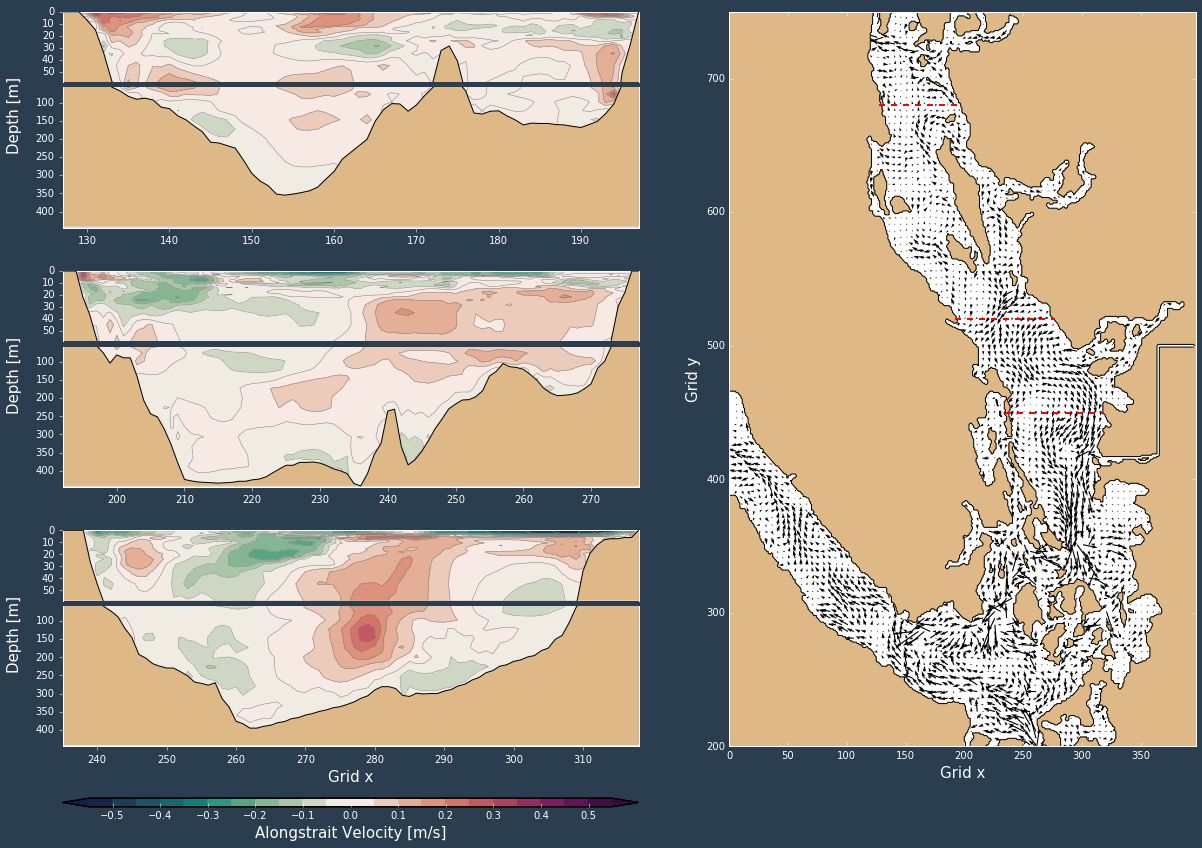

In [12]:
%%timeit -n1 -r1

# Layout parameters
sections = (450, 520, 680)
pos = (
    (0.1, 0.35),
    (0.4, 0.65),
    (0.7, 0.95)
)
section_lims = (
    (235, 318, 0, 445),
    (192, 277, 0, 445),
    (127, 197, 0, 445),
)

# Make figure
fig = make_figure(
    U_var, V_var, bathy, mesh_mask,
    sections=sections, pos=pos, section_lims=section_lims
)